## Grid Search Deep Learning Models for Univariate Forecasting
Grid searching is generally not feasible with deep learning methods because they often require large datasets and models, resulting in training times that can span hours, days, or even weeks. However, for smaller datasets, such as univariate time series, it may be possible to use grid search to tune the hyperparameters of a deep learning model.

### Hyperparameter Tuning in Deep Learning
- Hyperparameters are the settings or configurations external to the model that cannot be learned from the training data. 
- Examples include the learning rate, the number of layers, the number of neurons per layer, batch size, and the number of epochs.
- The choice of hyperparameters can significantly impact the model's performance, making hyperparameter tuning a crucial step in the modeling process.

### Grid Search: A Method for Hyperparameter Tuning
- Grid search is a systematic approach to hyperparameter tuning. 
- It involves specifying a set of possible values for each hyperparameter and evaluating the model's performance for every possible combination of these values.
- The goal is to identify the combination that results in the best performance according to a predefined metric, such as Mean Squared Error (MSE) or Mean Absolute Error (MAE).

### Challenges of Grid Search in Deep Learning
- While grid search is straightforward and exhaustive, it is computationally expensive, especially for deep learning models. 
- These models often have large parameter spaces and require significant computational resources and time to train.
- As a result, grid search can become impractical when dealing with large datasets or complex models.

### Summary
- Grid search, despite its computational demands, can be a valuable tool for tuning deep learning models in univariate forecasting. By systematically exploring the hyperparameter space, it helps in identifying the optimal settings that enhance model performance. 
- While alternative methods like __Random Search__ and __Bayesian Optimization__ can offer more efficient solutions, grid search remains a foundational technique for hyperparameter tuning in deep learning applications.

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from keras.models import Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM

         Passengers
Month              
1949-01         112
1949-02         118
1949-03         132
1949-04         129
1949-05         121
(144, 1)


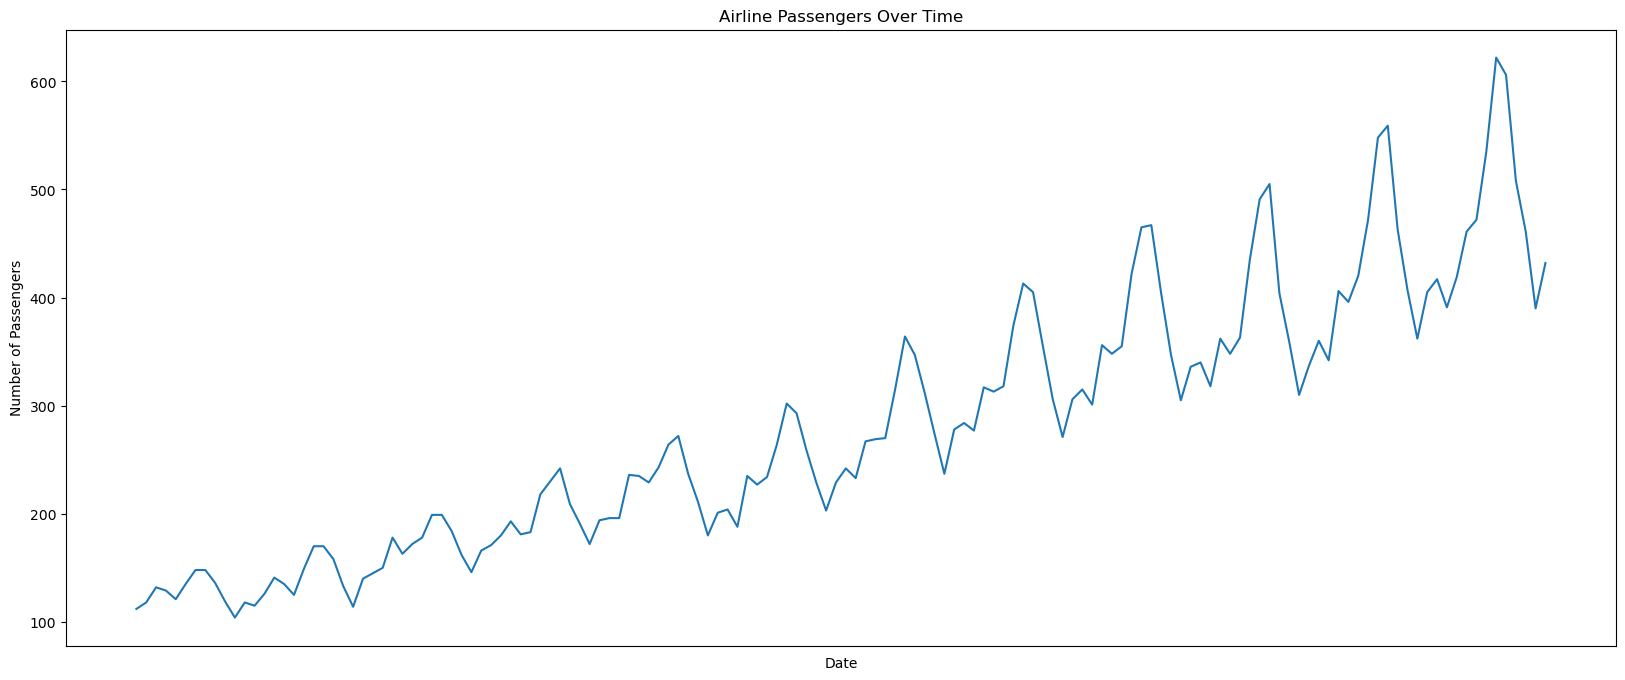

In [2]:
# Load the time series data
series = pd.read_csv('airline-passengers.csv', header=0, index_col=0)

print(series.head())

# Print the shape of the dataset (rows, columns)
print(series.shape)

# Plot the time series data with specified figure size
plt.figure(figsize=(20, 8))
plt.plot(series)
plt.title('Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.xticks([])
plt.show()

### Develop a Grid Search Framework
We will develop a network search test tool that can be used to evaluate a range of hyperparameters for different neural network models, such as MLPs, CNNs, and LSTMs. 

### 1. Train-Test Split

In [3]:
# split a univariate dataset into train/test sets
def train_test_split(data, test_size):
    return data[:-test_size], data[-test_size:]

### 2. Series as Supervised Learning 
To train neural network models, we need to frame the univariate time series as a supervised learning problem. This involves splitting the data into multiple examples that the model can learn from and generalize across. Each example must have both an input component and an output component.

In [4]:
def series_to_supervised(data, n_in, n_out=1):
    """
    Transform a time series into a supervised learning format.
    
    Parameters:
    data (list or array): The univariate time series data.
    n_in (int): The number of lag observations as input (X).
    n_out (int): The number of observations as output (y). Default is 1.
    
    Returns:
    ndarray: The transformed data suitable for supervised learning.
    """
    df = pd.DataFrame(data)
    cols = []

    # Create input sequence (t-n, ..., t-1)
    cols += [df.shift(i) for i in range(n_in, 0, -1)]
    
    # Create forecast sequence (t, t+1, ..., t+n)
    cols += [df.shift(-i) for i in range(n_out)]
    
    # Combine all sequences and drop rows with NaN values
    agg = pd.concat(cols, axis=1).dropna()
    
    return agg.values

In [5]:
print(series_to_supervised(series, 3, 1))

[[112. 118. 132. 129.]
 [118. 132. 129. 121.]
 [132. 129. 121. 135.]
 [129. 121. 135. 148.]
 [121. 135. 148. 148.]
 [135. 148. 148. 136.]
 [148. 148. 136. 119.]
 [148. 136. 119. 104.]
 [136. 119. 104. 118.]
 [119. 104. 118. 115.]
 [104. 118. 115. 126.]
 [118. 115. 126. 141.]
 [115. 126. 141. 135.]
 [126. 141. 135. 125.]
 [141. 135. 125. 149.]
 [135. 125. 149. 170.]
 [125. 149. 170. 170.]
 [149. 170. 170. 158.]
 [170. 170. 158. 133.]
 [170. 158. 133. 114.]
 [158. 133. 114. 140.]
 [133. 114. 140. 145.]
 [114. 140. 145. 150.]
 [140. 145. 150. 178.]
 [145. 150. 178. 163.]
 [150. 178. 163. 172.]
 [178. 163. 172. 178.]
 [163. 172. 178. 199.]
 [172. 178. 199. 199.]
 [178. 199. 199. 184.]
 [199. 199. 184. 162.]
 [199. 184. 162. 146.]
 [184. 162. 146. 166.]
 [162. 146. 166. 171.]
 [146. 166. 171. 180.]
 [166. 171. 180. 193.]
 [171. 180. 193. 181.]
 [180. 193. 181. 183.]
 [193. 181. 183. 218.]
 [181. 183. 218. 230.]
 [183. 218. 230. 242.]
 [218. 230. 242. 209.]
 [230. 242. 209. 191.]
 [242. 209.

### 3. Walk-Forward Validation
- Time series forecasting models can be evaluated on a test set using walk-forward validation.
- In this approach, the model makes a forecast for each observation in the test dataset one at a time.
- After each forecast, the true observation is added to the test dataset and made available to the model.
- Simpler models can be refit with this new observation before making the next prediction. However, more complex models, such as neural networks, are not typically refit due to the high computational cost. Instead, the true observation is used as part of the input for the next prediction.
- The prediction is added to a list of predictions, and the true observation from the test set is added to a list of observations, initially seeded with all training dataset observations. This list is built up during each step of walk-forward validation, allowing the model to make a one-step prediction using the most recent history.
- All predictions can then be compared to the true values in the test set, and an error measure can be calculated.e step.

In [5]:
# Fit a model (dummy function, replace with actual model fitting)
def model_fit(train, config):
    return None

# Forecast with a pre-fit model
def model_predict(model, history, offset):
    return history[-offset]

# Calculate root mean squared error (RMSE)
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [6]:
# Walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = []
    # Split dataset into training and test sets
    train, test = train_test_split(data, n_test)
    
    # Fit the model
    model = model_fit(train, cfg)
    # Seed history with the training dataset
    history = list(train)
    
    # Step over each time step in the test set
    for i in range(len(test)):
        # Make forecast for the current history
        yhat = model_predict(model, history, cfg)
        # Store the forecast in the list of predictions
        predictions.append(yhat)
        # Add actual observation to history for the next prediction
        history.append(test[i])
    
    # Estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

### 4. Repeat Evaluation
- Neural network models are stochastic, meaning that the same model configuration and training dataset can yield different internal weights and, consequently, different performances each time the model is trained.
- This variability allows the model to adapt and find high-performing configurations for complex problems. However, it poses a challenge when evaluating model performance and selecting a final model for predictions.
- To address this, we evaluate a model configuration multiple times using walk-forward validation and report the average error across all evaluations.
- This approach is more feasible for small neural networks that can be trained in minutes or hours, rather than larger networks.

In [7]:
# Score a model, returning None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    """
    Evaluate a model configuration multiple times and return the average score.
    
    Parameters:
    data (array-like): The dataset for model evaluation.
    config (dict): The model configuration.
    n_test (int): The number of test samples.
    n_repeats (int): The number of times to repeat the evaluation.
    
    Returns:
    tuple: A tuple containing the configuration key and the average score.
    """
    # Convert config to a string key
    key = str(config)
    
    # Fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    # Calculate and summarize the average score
    result = np.mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    
    return key, result

### 5. Grid Search
- We now have all the pieces of the framework. All that is left is a function to drive the search.
- We can define a grid_search() function that takes the dataset, a list of configurations to search, and the number of observations to use as the test set.
- This function performs the search, calculates the mean scores for each configuration, and sorts the configurations in ascending order so that the best scores are listed first.

In [8]:
# Grid search through configurations
def grid_search(data, cfg_list, n_test):
    """
    Perform a grid search to evaluate a list of configurations.
    
    Parameters:
    data (array-like): The dataset for model evaluation.
    cfg_list (list): A list of model configurations to evaluate.
    n_test (int): The number of test samples.
    
    Returns:
    list: A list of tuples with configuration and corresponding error, sorted by error.
    """
    # Evaluate each configuration
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    
    # Sort configurations by error in ascending order
    scores.sort(key=lambda tup: tup[1])
    
    return scores

### Airline Passengers Example

- Running the example prints the RMSE of the model evaluated using walk-forward validation on the final 12 months of data.
- Each model configuration is evaluated 10 times, but since the model has no stochastic element, the score is the same each time.
- At the end of the run, the configurations and RMSE for the top three performing models are reported.
- As expected, the persistence model with a relative offset of -12 (one year ago) performed the best.

In [9]:
# Define dataset
series = pd.read_csv('airline-passengers.csv', header=0, index_col=0)
data = series.values

# Number of test samples: We will use the first 11 years (132 observations) for training and the last 12 for the test set. 
n_test = 12

# Model configurations
cfg_list = [1, 6, 12, 24, 36]

# Perform grid search
scores = grid_search(data, cfg_list, n_test)
print('done')

# List top 10 configurations
for cfg, error in scores[:10]:
    print(cfg, error)

 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
> Model[1] 53.152
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
> Model[6] 126.735
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
> Model[12] 50.708
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
> Model[24] 97.110
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
> Model[36] 110.274
done
12 50.708316214732804
1 53.1515129919491
24 97.10990337413241
36 110.27352356753639
6 126.73495965991387


### Grid Search Hyperparameters for an MLPs for Univariate Time Series Forecasting

There are many aspects of the MLP that we may wish to tune. We will define a very simple
model with one hidden layer and define five hyperparameters to tune. They are:

__1. n_input:__ The number of lag observations (prior inputs) to use as input for the model (e.g. 12 months).

__2. n_nodes:__ The number of the number of neurons (nodes) in the __hidden layer__ of the neural network. More neurons can capture more complex patterns but also increase the computational cost and the risk of overfitting. (e.g. 50).

__3. n_epochs:__ The number of complete passes through the training dataset. More epochs can lead to better learning and improved model performance, up to a point where the model starts to overfit. (e.g. 1000).

__4. n_batch:__ The number of samples per mini-batch for training. A batch size of 1 means the model weights are updated after each sample, which can lead to a more robust model but is computationally expensive. A batch size of 150 updates the model weights after 150 samples, which can speed up training but might be less robust. Comparing both values helps determine the best trade-off between training speed and model performance. (e.g. 32).

__5. n_diff:__ The difference order. A value of 0 means no differencing, so the raw data is used. A value of 12 means the data is differenced with a lag of 12, which can help remove seasonality or trend from the data (e.g. 0 or 12).

### Effects of Batch Size on Training:

__1. Small Batch Size (e.g., 1):__
Training with a batch size of 1 means the model updates its weights after processing each individual sample. 
- __Advantages:__
  - Each update is noisy, which can help the model escape local minima and potentially find a better overall solution.
  - Often more robust and can generalize better, especially in complex and non-convex optimization problems.
  - Can be useful when dealing with small datasets where batch sizes larger than the dataset don't make sense.
  - Requires less memory, as only one sample needs to be stored and processed at a time.
- __Disadvantages:__
  - Training can be slow because the model updates weights very frequently.
  - The noisy updates might make convergence slower and more erratic.

__2. Large Batch Size (e.g., 150):__
Training with a large batch size means the model updates its weights after processing 150 samples. This is known as Mini-Batch Gradient Descent.
- __Advantages:__
  - More efficient computation, as modern hardware (like GPUs) can perform matrix operations on large batches more quickly than many individual updates.
  - Weight updates are more stable and less noisy, which can lead to faster convergence.
  - Can leverage parallelism better, making use of vectorized operations and potentially speeding up the training process.
- __Disadvantages:__
  - Requires more memory to store the batch of samples, which can be a limitation with very large batch sizes or limited hardware resources.
  - Larger batches might lead to poorer generalization, as the model might get "stuck" in sharp local minima due to less noisy updates.
  - Not suitable for very small datasets where the batch size might exceed the number of samples.

### Differencing hyperparameter
- Modern neural networks can handle raw data with minimal preprocessing, such as scaling and differencing. However, for time series data, differencing can sometimes simplify the modeling process.
- Differencing involves subtracting a prior observation from the current observation, which removes trend or seasonality.
- We will add support for optional differencing to the grid search test harness to see if it improves your specific problem. An order of 0 indicates no differencing, while an order of 1 or 12 indicates that the data will be differenced before fitting the model.
- Additionally, model predictions will need to have the differencing reversed before returning the forecast.

In [11]:
# Difference dataset
def difference(data, order):
    """
    Apply differencing to a dataset.
    
    Parameters:
    data (list or array): The time series data.
    order (int): The lag order to difference by.
    
    Returns:
    list: The differenced dataset.
    """
    return [data[i] - data[i - order] for i in range(order, len(data))]

### Multilayer Perceptron Model

In [12]:
# Fit a model
def model_fit(train, config):
    """
    Fit a neural network model.
    
    Parameters:
    train (list or array): Training data.
    config (list): Model configuration [n_input, n_nodes, n_epochs, n_batch, n_diff].
    
    Returns:
    model: Trained neural network model.
    """
    # Unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    
    # Apply differencing if required
    if n_diff > 0:
        train = difference(train, n_diff)
    
    # Transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    
    # Separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # Define and compile the model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

In [13]:
# Forecast with the fit model
def model_predict(model, history, config):
    """
    Make a forecast with a trained model.
    
    Parameters:
    model: Trained neural network model.
    history (list): Historical data.
    config (list): Model configuration [n_input, n_nodes, n_epochs, n_batch, n_diff].
    
    Returns:
    float: Forecasted value.
    """
    # Unpack config
    n_input, _, _, _, n_diff = config
    
    # Prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    
    # Shape input for the model
    x_input = np.array(history[-n_input:]).reshape((1, n_input))
    
    # Make forecast
    yhat = model.predict(x_input, verbose=0)
    
    # Correct forecast if it was differenced
    return correction + yhat[0]

In [14]:
# Create a list of configs to try
def model_configs():
    """
    Create a list of model configurations to try.
    
    Returns:
    list: List of model configurations.
    """
    # Define scope of configs
    n_input = [12]
    n_nodes = [50, 100]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    
    # Create configs
    configs = [[i, j, k, l, m] for i in n_input for j in n_nodes for k in n_epochs for l in n_batch for m in n_diff]
    
    print('Total configs: %d' % len(configs))
    return configs

In [15]:
# Define dataset
series = pd.read_csv('airline-passengers.csv', header=0, index_col=0)
data = series.values

# Data split
n_test = 12

# Model configs
cfg_list = model_configs()

# Grid search
scores = grid_search(data, cfg_list, n_test)
print('done')

# List top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 8
 > 19.298
 > 19.673
 > 18.098
 > 17.582
 > 17.658
 > 16.359
 > 23.120
 > 23.472
 > 18.809
 > 22.139
> Model[[12, 50, 100, 1, 0]] 19.621
 > 20.189
 > 21.292
 > 20.312
 > 20.708
 > 18.388
 > 19.811
 > 18.337
 > 19.466
 > 20.506
 > 18.524
> Model[[12, 50, 100, 1, 12]] 19.753
 > 70.935
 > 77.217
 > 41.234
 > 82.162
 > 75.894
 > 71.951
 > 63.688
 > 57.315
 > 33.440
 > 70.899
> Model[[12, 50, 100, 150, 0]] 64.474
 > 19.496
 > 18.422
 > 19.154
 > 21.471
 > 18.192
 > 19.029
 > 19.786
 > 19.715
 > 20.837
 > 18.986
> Model[[12, 50, 100, 150, 12]] 19.509
 > 22.030
 > 18.581
 > 21.509
 > 33.911
 > 23.316
 > 19.061
 > 22.444
 > 17.965
 > 20.982
 > 17.766
> Model[[12, 100, 100, 1, 0]] 21.757
 > 22.936
 > 20.755
 > 20.685
 > 20.809
 > 21.612
 > 18.488
 > 20.132
 > 19.809
 > 19.791
 > 18.998
> Model[[12, 100, 100, 1, 12]] 20.401
 > 54.417
 > 41.258
 > 35.162
 > 53.295
 > 72.945
 > 68.141
 > 78.580
 > 23.565
 > 53.837
 > 46.361
> Model[[12, 100, 100, 150, 0]] 52.756
 > 20.221
 > 19.663

### Convolutional Neural Network Model
The same set of hyperparameters can be searched as with the MLP model, except the number of nodes in the hidden layer is replaced by the number of filter maps and kernel size in the convolutional layers. The chosen set of hyperparameters to grid search in the CNN model are as follows:

__1. n_input:__ The number of prior inputs to use as input for the model (e.g., 12 months). Determines the size of the input window and helps the model capture temporal dependencies and patterns over that period.

__2. n_filters:__ The number of filter maps in the convolutional layer (e.g., 32). More filters can capture more features from the input data, but they also increase the computational complexity and risk of overfitting.

__3. n_kernel:__ The kernel size in the convolutional layer (e.g., 3). It determines how many input time steps each filter covers. Smaller kernels can capture fine details, while larger kernels can capture broader patterns.

__4. n_epochs:__ The number of training epochs (e.g., 1000). An epoch is one complete pass through the entire training dataset. This parameter specifies how many times the model will iterate over the training data. More epochs allow the model to learn more from the data, but too many epochs can lead to overfitting if not properly managed.

__5. n_batch:__ The number of samples to include in each mini-batch (e.g., 32). Smaller batch sizes lead to more frequent updates and potentially more robust training but can be slower. Larger batch sizes speed up training but may result in less frequent updates and less robust training.

__6. n_diff:__ The difference order (e.g., 0 or 12). Differencing helps remove trends or seasonality from the data, making it more stationary and easier to model. An order of 0 means no differencing is applied.

Additional hyperparameters you may wish to investigate include using two convolutional layers before a pooling layer, repeating the convolutional and pooling layer pattern, using dropout, and more. We will define a simple CNN model with one convolutional layer and one max pooling layer.

In [16]:
# Fit a CNN model
def model_fit(train, config):
    """
    Fit a CNN model.
    
    Parameters:
    train (array): Training data.
    config (list): Model configuration [n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff].
    
    Returns:
    model: Trained CNN model.
    """
    # Unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff = config
    
    # Apply differencing if required
    if n_diff > 0:
        train = difference(train, n_diff)
    
    # Transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    
    # Separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # Reshape input data into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    
    # Define and compile the model
    model = Sequential([
        Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, n_features)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

In [17]:
# Create a list of model configurations to try
def model_configs():
    """
    Create a list of model configurations to try.
    
    Returns:
    list: List of model configurations.
    """
    # Define scope of configs
    n_input = [12]
    n_filters = [64]
    n_kernels = [3, 5]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    
    # Create configs using list comprehension
    configs = [[a, b, c, d, e, f] for a in n_input for b in n_filters for c in n_kernels for d in n_epochs for e in n_batch for f in n_diff]
    
    print('Total configs: %d' % len(configs))
    return configs

In [18]:
# Forecast with the fit model
def model_predict(model, history, config):
    """
    Make a forecast with a trained model.
    
    Parameters:
    model: Trained Convolutional neural network model.
    history (list): Historical data.
    config (list): Model configuration [n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff].
    
    Returns:
    float: Forecasted value.
    """
    # Unpack configuration
    n_input, _, _, _, _, n_diff = config
    
    # Apply differencing correction if needed
    correction = history[-n_diff] if n_diff > 0 else 0.0
    history = difference(history, n_diff) if n_diff > 0 else history
    
    # Prepare input data for the model
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    
    # Make forecast
    yhat = model.predict(x_input, verbose=0)
    
    # Adjust forecast if differenced
    return correction + yhat[0][0]

In [19]:
# Define dataset
series = pd.read_csv('airline-passengers.csv', header=0, index_col=0)
data = series.values

# Data split
n_test = 12

# Model configs
cfg_list = model_configs()

# Grid search
scores = grid_search(data, cfg_list, n_test)
print('done')

# List top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 8
 > 20.939
 > 25.546
 > 19.648
 > 30.700
 > 31.053
 > 20.443
 > 18.500
 > 19.196
 > 17.460
 > 18.208
> Model[[12, 64, 3, 100, 1, 0]] 22.169
 > 19.678
 > 19.251
 > 19.795
 > 19.555
 > 20.527
 > 19.064
 > 21.007
 > 19.579
 > 18.510
 > 20.850
> Model[[12, 64, 3, 100, 1, 12]] 19.782
 > 70.618
 > 90.349
 > 84.891
 > 86.688
 > 78.175
 > 69.974
 > 75.778
 > 80.571
 > 71.920
 > 86.303
> Model[[12, 64, 3, 100, 150, 0]] 79.527
 > 19.369
 > 18.483
 > 18.592
 > 19.765
 > 19.840
 > 18.888
 > 19.079
 > 18.658
 > 20.038
 > 18.220
> Model[[12, 64, 3, 100, 150, 12]] 19.093
 > 23.273
 > 17.937
 > 21.441
 > 35.579
 > 18.467
 > 20.808
 > 28.482
 > 20.270
 > 25.003
 > 25.107
> Model[[12, 64, 5, 100, 1, 0]] 23.637
 > 18.756
 > 18.897
 > 18.274
 > 18.794
 > 17.580
 > 18.342
 > 18.707
 > 19.142
 > 20.667
 > 17.911
> Model[[12, 64, 5, 100, 1, 12]] 18.707
 > 82.315
 > 81.920
 > 89.066
 > 83.418
 > 73.009
 > 82.956
 > 79.375
 > 89.561
 > 77.223
 > 83.021
> Model[[12, 64, 5, 100, 150, 0]] 82.187
 

### Long Short-Term Memory Network Model
We can now adapt the framework for grid searching the hyperparameters of an LSTM model. The hyperparameters for the LSTM model are:

__1. n_input:__ The number of prior inputs to use as input for the model (e.g., 12 months).

__2. n_nodes:__ The number of nodes in the hidden layer (e.g., 50).

__3. n_epochs:__ The number of training epochs (e.g., 1000).

__4. n_batch:__ The number of samples in each mini-batch (e.g., 32).

__5. n_diff:__ The differencing order (e.g., 0 or 12).

We will define a simple LSTM model with a single hidden LSTM layer, where the number of nodes specifies the number of units in this layer.

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, test_size):
    return data[:-test_size], data[-test_size:]

In [22]:
# Forecast with the fit model
def model_predict(model, history, config):
    """
    Make a forecast with a trained model.
    
    Parameters:
    model: Trained neural network model.
    history (list): Historical data.
    config (list): Model configuration [n_input, n_nodes, n_epochs, n_batch, n_diff].
    
    Returns:
    float: Forecasted value.
    """
    # Unpack configuration
    n_input, _, _, _, n_diff = config
    
    # Prepare data
    correction = history[-n_diff] if n_diff > 0 else 0.0
    history = difference(history, n_diff) if n_diff > 0 else history
    
    # Reshape input for the model
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    
    # Make forecast
    yhat = model.predict(x_input, verbose=0)
    
    return correction + yhat[0][0]

In [23]:
# Create a list of model configurations to try
def model_configs():
    """
    Create a list of model configurations to try.
    
    Returns:
    list: List of model configurations.
    """
    # Define scope of configs
    n_input = [12]
    n_nodes = [100]
    n_epochs = [50]
    n_batch = [1, 150]
    n_diff = [12]
    
    # Create configs using list comprehension
    configs = [[i, j, k, l, m] for i in n_input for j in n_nodes for k in n_epochs for l in n_batch for m in n_diff]
    print('Total configs: %d' % len(configs))
    return configs

In [24]:
def model_fit(train, config):
    """
    Fit an LSTM model.
    
    Parameters:
    train (array): Training data.
    config (list): Model configuration [n_input, n_nodes, n_epochs, n_batch, n_diff].
    
    Returns:
    model: Trained LSTM model.
    """
    # Unpack configuration
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    
    # Apply differencing if required
    if n_diff > 0:
        train = difference(train, n_diff)
    
    # Transform series into supervised format
    data = series_to_supervised(train, n_input)
    
    # Separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # Reshape input data into [samples, timesteps, features]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    
    # Define and compile the LSTM model
    model = Sequential([
        LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)),
        Dense(n_nodes, activation='relu'),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

In [30]:
# Define dataset
series = pd.read_csv('airline-passengers.csv', header=0, index_col=0)
data = series.values

# Data split
n_test = 12

# Model configs
cfg_list = model_configs()

# Grid search
scores = grid_search(data, cfg_list, n_test)
print('done')

# List top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 2
 > 25.408
 > 18.050
 > 19.298
 > 28.530
 > 33.199
 > 27.627
 > 23.702
 > 24.945
 > 26.657
 > 19.431
> Model[[12, 100, 50, 1, 12]] 24.685
 > 22.956
 > 23.349
 > 20.534
 > 23.297
 > 19.643
 > 21.970
 > 19.672
 > 19.893
 > 21.074
 > 21.646
> Model[[12, 100, 50, 150, 12]] 21.403
done
[12, 100, 50, 150, 12] 21.403351562369274
[12, 100, 50, 1, 12] 24.684602766875376
